# Structural Time Series

## The model

<font size="3"> Let $\pmb{y} = (y_1, \ldots, y_n)$ denote the time series of interest. In general, a structural time series models is comprised of two equations, an *observation equation* and a *transition equation*. It is the assumption of the model that $y_t$ is influenced by a vector of unobserved latent state variables, denoted as $\alpha_t$. Explicity, the relation between $y_t$ and $\alpha_t$ is described by <font>

<font size="3"> \begin{align}&y_t = Z_t \alpha_t + \varepsilon_t, \qquad &\varepsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2) \tag{1}\\ &\alpha_{t+1} = T_t \alpha_{t} + R_{t} \eta_{t}, \qquad &\eta_{t} \sim \mathcal{N}(0, Q_{t}), \tag{2}\end{align} <font>

<font size="3"> where (1) is the *observation equation* and (2) is the *transition equation*. For our purposes, we will use the specific structural time series model <font>

<font size="3"> \begin{align*} &y_t = \mu_t + \tau_t + X_t\beta + \varepsilon_t, \qquad &&\varepsilon_t \sim \mathcal{N}(0, \sigma_{\epsilon}^2) \\ &\mu_t = \mu_{t-1} + \delta_{t-1} + u_t, \qquad &&u_t \sim \mathcal{N}(0, \sigma_{u}^2)\\ &\delta_t = \delta_{t-1} + v_t, \qquad &&v_t \sim \mathcal{N}(0, \sigma_{v}^2) \\ &\tau_t = - \sum_{s = 1}^{S-1} \tau_{t-s} + w_t, \qquad &&w_t \sim \mathcal{N}(0, \sigma_{w}^2)\end{align*} <font>

<font size="3">where we assume that $\varepsilon_t$, $u_t$, $v_t$ and $w_t$ are independent centered Gaussian random variables with constant variances. Additionaly, we also assume that the regression coefficients remain constant throughout time. The parameters that are to be learnt in this model are the variances of the noise components  $\sigma_{\epsilon}^2, \sigma_u^2, \sigma_v^2, \sigma_w^2$, and the regression coefficients, $\beta \in \mathbb{R}^d$. We concisely denote these parameters as $\phi = (\sigma_{\epsilon}^2, \sigma_u^2, \sigma_v^2, \sigma_w^2, \beta)$. <font>

In [2]:
import random
import time
import math
import numpy as np
import statsmodels.api as sm
import pandas as pd
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go
import polars as pl
import seaborn as sns
from datetime import datetime
from collections import Counter

## Data Loading and Feature Engineering

<font size="3">Here we import the dataset and apply the same feature engineering as described in the notebook ```mlfcs/experiments/miro
/2.0-mz-preprocessing.ipynb```.<font>

In [5]:
random.seed(0)
np.random.seed(0)

LAST_TRAINING_DATE = datetime.strptime("2018-07-01 00:00:00", "%Y-%m-%d %H:%M:%S")

full_data = (pl.read_csv("btc/data_df_with_volume.csv")
             .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
             .sort("datetime")).to_pandas().set_index("datetime")

full_data["vol"] = np.log(full_data["vol"])
full_data["volume"] = np.log(full_data["volume"])
full_data.rename(columns={ 'vol': 'log_vol' }, inplace=True)
full_data.rename(columns={ 'volume': 'log_volume' }, inplace=True)


full_data = full_data.copy().drop(columns=[col for col in full_data.columns 
                                           if col.startswith('ret') or
                                           col.startswith('ask_depth') or
                                           col.startswith('depth_diff')])

In [6]:
full_data = full_data.copy().drop(columns=[col for col in full_data.columns if col.startswith('volume_diff')])
print(f"Number of features: {full_data.shape[1] - 1}")

Number of features: 841


<font size="3">We now add log-volatility features to the dataset.<font>

In [8]:
log_vol_index = full_data.columns.get_loc("log_vol")

full_data.insert(loc=log_vol_index + 1,
                 column="log_vol_ma24",
                 value=full_data["log_vol"].shift(1).rolling(window=24).mean())

full_data.insert(loc=log_vol_index + 1,
                 column="log_vol_ma6",
                 value=full_data["log_vol"].shift(1).rolling(window=6).mean())

full_data.insert(loc=log_vol_index + 1,
                 column="log_vol_t-1",
                 value=full_data["log_vol"].shift(1))


full_data = full_data.dropna()

In [9]:
full_data

log_vol  log_vol_t-1  log_vol_ma6  log_vol_ma24  \
datetime                                                                 
2018-06-05 23:00:00  -9.395672    -9.600540    -8.916600     -8.673882   
2018-06-06 00:00:00  -9.348389    -9.395672    -9.063109     -8.696391   
2018-06-06 01:00:00  -9.185994    -9.348389    -9.262724     -8.708069   
2018-06-06 02:00:00  -9.482964    -9.185994    -9.203051     -8.702541   
2018-06-06 03:00:00  -9.069514    -9.482964    -9.254608     -8.781163   
...                        ...          ...          ...           ...   
2018-09-30 17:00:00 -10.582381   -10.582816   -10.742739    -10.363791   
2018-09-30 18:00:00 -11.200888   -10.582381   -10.727725    -10.396945   
2018-09-30 19:00:00 -10.642258   -11.200888   -10.879202    -10.436798   
2018-09-30 20:00:00  -9.324592   -10.642258   -10.729416    -10.458969   
2018-09-30 21:00:00 -10.285905    -9.324592   -10.446902    -10.487336   

                     spread_t-1  bid_depth_t-1  ask_volume_t-1  \
datetime                                                         
2018-06-05 23:00:00        3.02         2847.0     2247.548011   
2018-06-06 00:00:00        4.98         2864.0     2272.821229   
2018-06-06 01:00:00        5.97         2864.0     2303.913832   
2018-06-06 02:00:00        8.02         2864.0     2279.082323   
2018-06-06 03:00:00        7.48         2858.0     2329.881418   
...                         ...            ...             ...   
2018-09-30 17:00:00        2.51         2837.0     2634.212985   
2018-09-30 18:00:00        0.08         2841.0     2627.386158   
2018-09-30 19:00:00        3.11         2844.0     2614.121173   
2018-09-30 20:00:00        3.89         2841.0     2596.782862   
2018-09-30 21:00:00        0.99         2844.0     2605.255754   

                     bid_volume_t-1  weighted_spread_t-1  ask_slope_t-1  ...  \
datetime                                                                 ...   
2018-06-05 23:00:00    12582.701382          1047.332839        7673.23  ...   
2018-06-06 00:00:00    12597.542881          1084.836117        7676.27  ...   
2018-06-06 01:00:00    12628.213499          1122.776876        7668.97  ...   
2018-06-06 02:00:00    12635.583395          1125.756027        7659.00  ...   
2018-06-06 03:00:00    12602.886330          1082.952454        7685.31  ...   
...                             ...                  ...            ...  ...   
2018-09-30 17:00:00    11905.433650           990.015651        6618.00  ...   
2018-09-30 18:00:00    11908.671066          1050.033244        6629.00  ...   
2018-09-30 19:00:00    11901.490484           971.968267        6631.00  ...   
2018-09-30 20:00:00    11936.792886          1066.959713        6628.00  ...   
2018-09-30 21:00:00    11981.766011          1072.132172        6618.00  ...   

                     ask_slope_t-119  bid_slope_t-119  spread_t-120  \
datetime                                                              
2018-06-05 23:00:00          7693.29           7010.0          0.01   
2018-06-06 00:00:00          7668.29           7010.0          5.99   
2018-06-06 01:00:00          7660.89           7010.0          5.37   
2018-06-06 02:00:00          7694.92           7010.0          8.77   
2018-06-06 03:00:00          7674.41           7010.0          6.59   
...                              ...              ...           ...   
2018-09-30 17:00:00          6629.00           6060.0          0.08   
2018-09-30 18:00:00          6631.00           6060.0          3.13   
2018-09-30 19:00:00          6628.00           6060.0          3.89   
2018-09-30 20:00:00          6618.00           6060.0          0.99   
2018-09-30 21:00:00          6590.19           6060.0          0.76   

                     bid_depth_t-120  ask_volume_t-120  bid_volume_t-120  \
datetime                                                                   
2018-06-05 23:00:00           2864.0       2267.903872      12596.326211   
2018-06-

<font size="3">We now generate the final OB features.<font>

In [11]:
ct_features = ["spread", 
               "bid_depth", 
               "ask_volume"]

for col in ct_features:
    full_data[f"mean_{col}"] = full_data.loc[:, full_data.columns.str.startswith(col)].mean(axis=1)

disp_features = ["bid_depth",
                 "ask_volume",
                 "ask_slope"]

for col in disp_features:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))
    full_data[f"iq_range_{col}"] = np.log(0.0001+(full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1) - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1))/ full_data.loc[:, columns_to_use[:]].median(axis=1))
    

In [12]:
final_features = ["log_vol_t-1"] + \
                 ["log_vol_ma6"] + \
                 ["log_vol_ma24"] + \
                 ["log_volume"] + \
                 [f"mean_{col}" for col in ct_features] + \
                 [f"iq_range_{col}" for col in disp_features]

In [13]:
full_data = full_data.loc[:, ["log_vol"] + final_features]
full_data

log_vol  log_vol_t-1  log_vol_ma6  log_vol_ma24  \
datetime                                                                 
2018-06-05 23:00:00  -9.395672    -9.600540    -8.916600     -8.673882   
2018-06-06 00:00:00  -9.348389    -9.395672    -9.063109     -8.696391   
2018-06-06 01:00:00  -9.185994    -9.348389    -9.262724     -8.708069   
2018-06-06 02:00:00  -9.482964    -9.185994    -9.203051     -8.702541   
2018-06-06 03:00:00  -9.069514    -9.482964    -9.254608     -8.781163   
...                        ...          ...          ...           ...   
2018-09-30 17:00:00 -10.582381   -10.582816   -10.742739    -10.363791   
2018-09-30 18:00:00 -11.200888   -10.582381   -10.727725    -10.396945   
2018-09-30 19:00:00 -10.642258   -11.200888   -10.879202    -10.436798   
2018-09-30 20:00:00  -9.324592   -10.642258   -10.729416    -10.458969   
2018-09-30 21:00:00 -10.285905    -9.324592   -10.446902    -10.487336   

                     log_volume  mean_spread  mean_bid_depth  mean_ask_volume  \
datetime                                                                        
2018-06-05 23:00:00    4.595965     4.339000     2854.916667      2242.934275   
2018-06-06 00:00:00    4.041086     4.669583     2860.983333      2280.225762   
2018-06-06 01:00:00    4.735400     5.221000     2862.116667      2276.860574   
2018-06-06 02:00:00    5.327580     4.654083     2860.375000      2315.646031   
2018-06-06 03:00:00    4.499403     4.913000     2858.625000      2342.686001   
...                         ...          ...             ...              ...   
2018-09-30 17:00:00    4.657951     2.713750     2839.141667      2626.154969   
2018-09-30 18:00:00    3.293007     3.495083     2842.358333      2610.819406   
2018-09-30 19:00:00    3.895184     2.176917     2844.933333      2596.672610   
2018-09-30 20:00:00    4.574346     2.509667     2843.958333      2602.835693   
2018-09-30 21:00:00    5.672384     3.018167     2838.291667      2659.465413   

                     iq_range_bid_depth  iq_range_ask_volume  \
datetime                                                       
2018-06-05 23:00:00           -6.118582            -5.075595   
2018-06-06 00:00:00           -7.132079            -4.212557   
2018-06-06 01:00:00           -6.769863            -4.158290   
2018-06-06 02:00:00           -5.972286            -4.296181   
2018-06-06 03:00:00           -7.131467            -5.036392   
...                                 ...                  ...   
2018-09-30 17:00:00           -7.125323            -5.725597   
2018-09-30 18:00:00           -6.763462            -5.195273   
2018-09-30 19:00:00           -7.127171            -5.988073   
2018-09-30 20:00:00           -6.497986            -5.725526   
2018-09-30 21:00:00           -6.286543            -4.048917   

                     iq_range_ask_slope  
datetime                                 
2018-06-05 23:00:00           -7.587819  
2018-06-06 00:00:00           -6.813087  
2018-06-06 01:00:00           -6.831365  
2018-06-06 02:00:00           -7.102543  
2018-06-06 03:00:00           -6.521619  
...                                 ...  
2018-09-30 17:00:00           -7.500707  
2018-09-30 18:00:00           -6.743640  
2018-09-30 19:00:00           -7.501572  
2018-09-30 20:00:00           -6.184382  
2018-09-30 21:00:00           -5.796392  

[2555 rows x 11 columns]

In [14]:
model_output = pd.read_csv("Model_output_template.csv")
model_output["datetime"] = pd.to_datetime(model_output["datetime"])

mask = full_data.index.isin(model_output["datetime"])

test_vols = full_data.loc[mask]
retrain_times = model_output.loc[model_output["retraining_flag"], "datetime"].sort_values()
retrain_times = pd.to_datetime(retrain_times)

<font size="3">The following function splits the full dataset into the chosen training/testing datasets. It returns a list of ```(train_set, test_set)``` tuples. <font>

In [16]:
def get_train_test_pairs(full_data,
                         retrain_times,
                         lookback = pd.Timedelta(days=30),
                         freq_lag = pd.Timedelta(hours=1), 
                         expanding=False):
    df = full_data.copy()
    df.index = pd.to_datetime(df.index)

    pairs = []
    for cur_test, next_test in zip(retrain_times, retrain_times.shift(-1)):
        if expanding:
            train_start = df.index.min()
        else:
            train_start = cur_test - lookback
            
        train_end = cur_test - freq_lag
        train = df.loc[train_start : train_end]

        if pd.isna(next_test):
            test = df.loc[cur_test :]
        else:
            test = df.loc[cur_test : next_test - pd.Timedelta(microseconds=1)]
        pairs.append((train, test))
        
    return pairs

In [17]:
rolling_train_test_pairs = get_train_test_pairs(full_data,
                                                retrain_times)
expanding_train_test_pairs = get_train_test_pairs(full_data,
                                                  retrain_times,
                                                  expanding=True)

## The Structural Time Series Models

<font size="3">The following backtester goes through a provided list of training/testing set tuples, fits a predefined structural time series model to the training set, and performs a one-step ahead forecast over the corresponding testing set. The models are then retrained at the window boundaries.
<font>

<font size="3">Additionally, the backtester can also track the p-values of the structural time series models and exogenous features over the various training sets. It can then plot the p-values that at least once achieve a p-value of less than or equal to 0.05 over the different training sets.
<font>

<font size="3">Because the volatility exhibits no discernible seasonality, we decided to restrict ourselves to the structural time series models with a level component $\mu_t$ and potentially also a trend component $\delta_t$.
<font>

In [20]:
def back_tester(train_test_pairs,
                model_output_temp=model_output,
                order_book_feats=False,
                trend=False,
                naive=False,
                plot=False):
    model_output_res = model_output_temp.copy()
    if naive:
        model_output_res = model_output_res.rename(columns={"model_name": "Naive"})
    else:
        if order_book_feats:
            model_output_res = model_output_res.rename(columns={"model_name": "STRX"})
        else:
            model_output_res = model_output_res.rename(columns={"model_name": "STR"})
    all_pvalues = []
    for cur_train_set, cur_test_set in train_test_pairs:
        if naive:
            combined_log = pd.concat([cur_train_set["log_vol"],
                                      cur_test_set["log_vol"]]).sort_index()
            naive_log_preds = combined_log.shift(1).loc[cur_test_set.index]
            vol_preds = np.exp(naive_log_preds.values)
            vol_preds_pd = pd.Series(vol_preds, index=cur_test_set.index)
            mapped = model_output_res["datetime"].map(vol_preds_pd)
            model_output_res["Naive"] = model_output_res["Naive"].fillna(mapped)
            continue

        cur_y_train = cur_train_set["log_vol"].values.reshape(-1, 1)
        if order_book_feats:
            feature_df = cur_train_set.drop(columns=["log_vol"])
        else:
            feature_df = cur_train_set.loc[:, [col for col in cur_train_set.columns if col.startswith("log_vol_")]]
        X_cols = feature_df.columns.tolist()
        cur_X_train = feature_df.values

        X_scaler = StandardScaler().fit(cur_X_train)
        y_scaler = StandardScaler().fit(cur_y_train)
        cur_X_train_std = X_scaler.transform(cur_X_train)
        cur_y_train_std = y_scaler.transform(cur_y_train)

        if trend:
            cur_model = sm.tsa.UnobservedComponents(endog=cur_y_train_std,
                                                    level="lltrend",
                                                    exog=cur_X_train_std)
        else:
            cur_model = sm.tsa.UnobservedComponents(endog=cur_y_train_std,
                                                    level="llevel",
                                                    exog=cur_X_train_std)
        cur_fitted_model = cur_model.fit(method="powell", disp=False)

        param_names = cur_fitted_model.param_names
        raw_pvals   = cur_fitted_model.pvalues
        new_index   = []
        beta_counter = 0
        for pname in param_names:
            if pname.startswith("beta"):
                new_index.append(X_cols[beta_counter])
                beta_counter += 1
            else:
                new_index.append(pname)
        pval_series = pd.Series(raw_pvals, index=new_index)
        pval_series.name = cur_train_set.index[-1]
        all_pvalues.append(pval_series)

        cur_y_test = cur_test_set["log_vol"].values.reshape(-1, 1)
        if order_book_feats:
            test_feature_df = cur_test_set.drop(columns=["log_vol"])
        else:
            test_feature_df = cur_test_set.loc[:, [col for col in cur_test_set.columns if col.startswith("log_vol_")]]
        cur_X_test = test_feature_df.values
        cur_y_test_std = y_scaler.transform(cur_y_test).ravel()
        cur_X_test_std = X_scaler.transform(cur_X_test)

        pred_means_std = []
        pred_std_std   = []
        for j in range(len(cur_test_set)):
            pred = cur_fitted_model.get_forecast(steps=1,
                                                 exog=cur_X_test_std[j:j+1])
            pred_means_std.append(pred.predicted_mean[0])
            pred_std_std.append(pred.se_mean[0])
            cur_fitted_model = cur_fitted_model.append(endog=cur_y_test_std[j:j+1].ravel(),
                                                       exog=cur_X_test_std[j:j+1],
                                                       refit=False)

        mean_arr  = np.array(pred_means_std).reshape(-1, 1)
        std_arr   = np.array(pred_std_std).reshape(-1, 1)
        mean_orig = y_scaler.inverse_transform(mean_arr).ravel()
        std_orig  = std_arr * y_scaler.scale_[0]
        vol_preds = np.exp(mean_orig + 0.5 * (std_orig.ravel()**2))

        vol_preds_pd = pd.Series(vol_preds, index=cur_test_set.index)
        mapped = model_output_res["datetime"].map(vol_preds_pd)
        if order_book_feats:
            model_output_res["STRX"] = model_output_res["STRX"].fillna(mapped)
        else:
            model_output_res["STR"]  = model_output_res["STR"].fillna(mapped)

    pvalues_df = pd.DataFrame(all_pvalues)

    if plot:
        all_params = pvalues_df.columns.tolist()
        #to_plot = [param for param in all_params if (pvalues_df[param] < 0.05).any()]
        to_plot = all_params
        never_cross = [param for param in all_params if (pvalues_df[param] >= 0.05).all()]

        print("Parameters that never had p-value < 0.05:")
        print(never_cross)

        fig_pvals = go.Figure()

        for param in to_plot:
            fig_pvals.add_trace(go.Scatter(x=pvalues_df.index,
                                           y=pvalues_df[param],
                                           mode="lines",
                                           name=param,
                                           opacity=0.6))

        fig_pvals.add_trace(go.Scatter(x=[pvalues_df.index.min(), pvalues_df.index.max()],
                                       y=[0.05, 0.05],
                                       mode="lines",
                                       name="0.05 threshold",
                                       line=dict(color="black", dash="dash")))

        fig_pvals.update_layout(height=600,
                                width=1000,
                                margin=dict(l=40, r=40, t=50, b=50),
                                title=dict(text="Rolling-Window p-Values (<0.05) for Each Parameter",
                                           x=0.5,
                                           xanchor="center",
                                           y=0.98,
                                           font=dict(size=20)),
                                xaxis=dict(title="Training Window End Date",
                                           tickangle=45),
                                yaxis=dict(title="p-Value",
                                           range=[0.0, 1.05]),
                                legend=dict(orientation="v",
                                            xanchor="left",
                                            x=1.02,
                                            yanchor="top",
                                            y=0.98,
                                            font=dict(size=12),
                                            title_text=""))
        fig_pvals.show()
        
    if order_book_feats:
        if trend:
            pvalues_df.to_csv("BSTS Results/STRX_lltrend_all_window_pvalues.csv")
        else:
            pvalues_df.to_csv("BSTS Results/STRX_llevel_all_window_pvalues.csv")
    else:
        if trend:
            pvalues_df.to_csv("BSTS Results/STR_lltrend_all_window_pvalues.csv")
        else:
            pvalues_df.to_csv("BSTS Results/STR_llevel_all_window_pvalues.csv")
            
    return model_output_res

<font size="3">This helper function preduces an interactive plot of the predicted values by a given model against the realized volatility.<font>

In [22]:

def plot_preds(preds_dataframe,
               model_name,
               test_vols,
               naive=False,
               orderbook_feats=False,
               pred_type="rolling"):
    if naive:
        preds_dataframe["datetime"] = pd.to_datetime(preds_dataframe["datetime"])
        test_vols = test_vols.copy()
        test_vols.index = pd.to_datetime(test_vols.index)

        fig = go.Figure(layout=dict(height=600,
                                    width=1000,
                                    margin=dict(l=40, r=40, t=50, b=50)))
        fig.add_trace(go.Scatter(x=test_vols.index,
                                 y=np.exp(test_vols["log_vol"]),
                                 mode="lines",
                                 name="Realized Volatility",
                                 opacity=0.5))
        fig.add_trace(go.Scatter(x=preds_dataframe["datetime"],
                                 y=preds_dataframe["Naive"],
                                 mode="lines",
                                 name="Predicted Volatility"))
        fig.update_layout(title=dict(text=model_name,
                                         x=0.5,
                                         xanchor="center",
                                         y=0.98,
                                         font=dict(size=20)),
                              xaxis=dict(title="Datetime", tickangle=45),
                              yaxis=dict(title="Volatility"))
        fig.show()

    else:
        preds_dataframe["datetime"] = pd.to_datetime(preds_dataframe["datetime"])
        test_vols = test_vols.copy()
        test_vols.index = pd.to_datetime(test_vols.index)

        if orderbook_feats:
            fig = go.Figure(layout=dict(height=600,
                                        width=1000,
                                        margin=dict(l=40, r=40, t=50, b=50)))
            fig.add_trace(go.Scatter(x=test_vols.index,
                                     y=np.exp(test_vols["log_vol"]),
                                     mode="lines",
                                     name="True vol",
                                     opacity=0.5))
            fig.add_trace(go.Scatter(x=preds_dataframe["datetime"],
                                     y=preds_dataframe["STRX"],
                                     mode="lines",
                                     name="Predicted vols"))
            fig.update_layout(title=f"STRX, {model_name} ({pred_type})",
                              xaxis=dict(title="Datetime", tickangle=45),
                              yaxis=dict(title="Volatility"))
            fig.show()
        else:
            fig = go.Figure(layout=dict(height=600,
                                        width=1000,
                                        margin=dict(l=40, r=40, t=50, b=50)))
            fig.add_trace(go.Scatter(x=test_vols.index,
                                     y=np.exp(test_vols["log_vol"]),
                                     mode="lines",
                                     name="True vol",
                                     opacity=0.5))
            fig.add_trace(go.Scatter(x=preds_dataframe["datetime"],
                                     y=preds_dataframe["STR"],
                                     mode="lines",
                                     name="Predicted vols"))
            fig.update_layout(title=dict(text=f"STR, {model_name} ({pred_type})",
                                         x=0.5,
                                         xanchor="center",
                                         y=0.98,
                                         font=dict(size=20)),
                              xaxis=dict(title="Datetime", tickangle=45),
                              yaxis=dict(title="Volatility"))
            fig.show()



### Naive Predictor

In [24]:
naive_pred = back_tester(expanding_train_test_pairs, 
                         model_output_temp=model_output,
                         naive=True)

naive_pred.to_csv("BSTS Results/naive_pred.csv")

In [25]:
print(f'Naive rolling RMSE = {root_mean_squared_error(naive_pred["Naive"].values, np.exp(test_vols["log_vol"]))*1e3}')
print(f'Naive rolling MAE = {mean_absolute_error(naive_pred["Naive"].values, np.exp(test_vols["log_vol"]))*1e3}')

Naive rolling RMSE = 0.2826151911814271
Naive rolling MAE = 0.09213546718779356


In [26]:
plot_preds(preds_dataframe=naive_pred,
           model_name="Naive Predictor",
           test_vols=test_vols,
           naive=True)

## Rolling Predictions

### STR Local Level

Parameters that never had p-value < 0.05:
['sigma2.level']


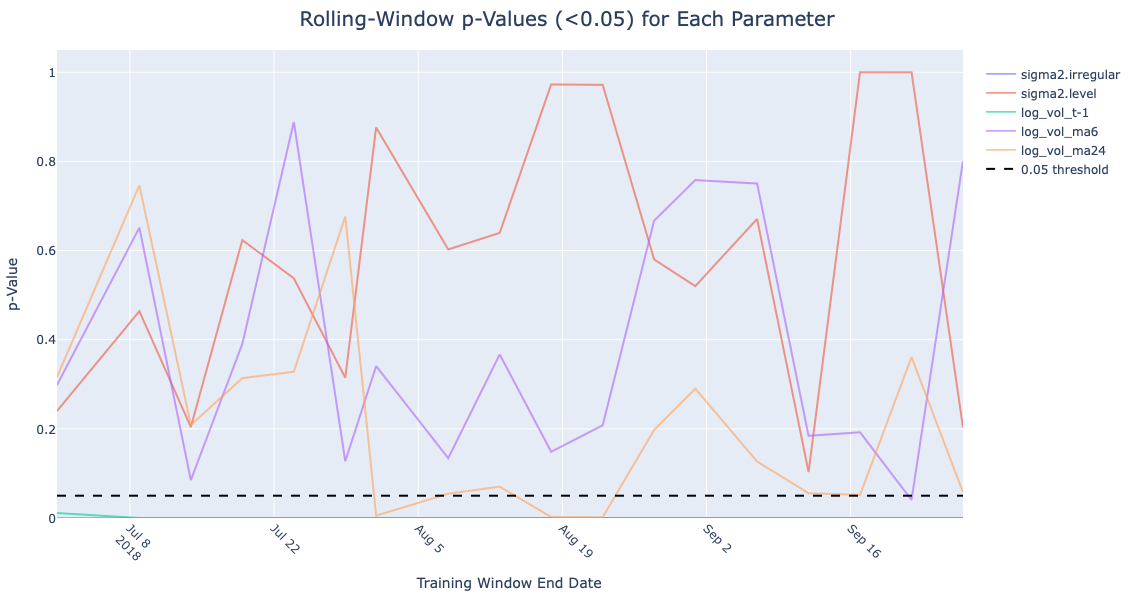

In [29]:
STR_llevel_rolling = back_tester(train_test_pairs=rolling_train_test_pairs,
                                 model_output_temp=model_output,
                                 order_book_feats=False,
                                 trend=False,
                                 naive=False,
                                 plot=True)

STR_llevel_rolling.to_csv("BSTS Results/STR_llevel_rolling.csv")

In [30]:
plot_preds(preds_dataframe=STR_llevel_rolling,
           model_name="Local Level",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=False,
           pred_type="rolling")

In [31]:
print(f'STR Local Level rolling RMSE = {root_mean_squared_error(STR_llevel_rolling["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STR Local Level rolling MAE = {mean_absolute_error(STR_llevel_rolling["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STR Local Level rolling RMSE = 0.22872118178832868
STR Local Level rolling MAE = 0.07556496145913123


### STR Local Linear Trend

In [33]:
STR_lltrend_rolling = back_tester(train_test_pairs=rolling_train_test_pairs,
                                  model_output_temp=model_output,
                                  order_book_feats=False,
                                  trend=True,
                                  naive=False,
                                  plot=True)

STR_lltrend_rolling.to_csv("BSTS Results/STR_lltrend_rolling.csv")

Parameters that never had p-value < 0.05:
['sigma2.level', 'sigma2.trend', 'log_vol_ma24']


In [34]:
plot_preds(preds_dataframe=STR_lltrend_rolling,
           model_name="Local Linear Trend",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=False,
           pred_type="rolling")

In [35]:
print(f'STR Local Linear Trend rolling RMSE = {root_mean_squared_error(STR_lltrend_rolling["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STR Local Linear Trend rolling MAE = {mean_absolute_error(STR_lltrend_rolling["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STR Local Linear Trend rolling RMSE = 0.2290016823358644
STR Local Linear Trend rolling MAE = 0.07525453970503447


### STRX Local Level

In [37]:
STRX_llevel_rolling = back_tester(train_test_pairs=rolling_train_test_pairs,
                                  model_output_temp=model_output,
                                  order_book_feats=True,
                                  trend=False,
                                  naive=False,
                                  plot=True)

STRX_llevel_rolling.to_csv("BSTS Results/STRX_llevel_rolling.csv")

Parameters that never had p-value < 0.05:
['sigma2.level', 'log_vol_ma6', 'iq_range_bid_depth', 'iq_range_ask_slope']


In [38]:
plot_preds(preds_dataframe=STRX_llevel_rolling,
           model_name="Local Level",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=True,
           pred_type="rolling")

In [39]:
print(f'STRX Local Level rolling RMSE = {root_mean_squared_error(STRX_llevel_rolling["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STRX Local Level rolling MAE = {mean_absolute_error(STRX_llevel_rolling["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STRX Local Level rolling RMSE = 0.23071102150746667
STRX Local Level rolling MAE = 0.07632297476442623


### STRX Local Linear Trend

In [41]:
STRX_lltrend_rolling = back_tester(train_test_pairs=rolling_train_test_pairs,
                                   model_output_temp=model_output,
                                   order_book_feats=True,
                                   trend=True,
                                   naive=False,
                                   plot=True)

STRX_lltrend_rolling.to_csv("BSTS Results/STRX_lltrend_rolling.csv")

Parameters that never had p-value < 0.05:
['sigma2.level', 'sigma2.trend', 'log_volume', 'mean_bid_depth', 'mean_ask_volume', 'iq_range_bid_depth', 'iq_range_ask_slope']


In [42]:
plot_preds(preds_dataframe=STRX_lltrend_rolling,
           model_name="Local Linear Trend",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=True,
           pred_type="rolling")

In [43]:
print(f'STRX Local Linear Trend rolling RMSE = {root_mean_squared_error(STRX_lltrend_rolling["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STRX Local Linear Trend rolling MAE = {mean_absolute_error(STRX_lltrend_rolling["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STRX Local Linear Trend rolling RMSE = 0.23122720992689355
STRX Local Linear Trend rolling MAE = 0.07456917984484315


## Expanding Predictions

### STR Local Level

In [46]:
STR_llevel_expanding = back_tester(train_test_pairs=expanding_train_test_pairs,
                                   model_output_temp=model_output,
                                   order_book_feats=False,
                                   trend=False,
                                   naive=False,
                                   plot=True)

STR_llevel_expanding.to_csv("BSTS Results/STR_llevel_expanding.csv")

Parameters that never had p-value < 0.05:
['sigma2.level']


In [47]:
plot_preds(preds_dataframe=STR_llevel_expanding,
           model_name="Local Level",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=False,
           pred_type="expanding")

In [48]:
print(f'STR Local Level expanding RMSE = {root_mean_squared_error(STR_llevel_expanding["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STR Local Level expanding MAE = {mean_absolute_error(STR_llevel_expanding["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STR Local Level expanding RMSE = 0.2279114940281447
STR Local Level expanding MAE = 0.07473673999791344


### STR Local Linear Trend

In [50]:
STR_lltrend_expanding = back_tester(train_test_pairs=expanding_train_test_pairs,
                                  model_output_temp=model_output,
                                  order_book_feats=False,
                                  trend=True,
                                  naive=False,
                                  plot=True)

STR_lltrend_expanding.to_csv("BSTS Results/STR_lltrend_expanding.csv")

Parameters that never had p-value < 0.05:
['sigma2.level', 'sigma2.trend']


In [51]:
plot_preds(preds_dataframe=STR_lltrend_expanding,
           model_name="Local Linear Trend",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=False,
           pred_type="expanding")

In [52]:
print(f'STR Local Linear Trend expanding RMSE = {root_mean_squared_error(STR_lltrend_expanding["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STR Local Linear Trend expanding MAE = {mean_absolute_error(STR_lltrend_expanding["STR"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STR Local Linear Trend expanding RMSE = 0.22817569455375983
STR Local Linear Trend expanding MAE = 0.07418086878763196


### STRX Local Level

In [54]:
STRX_llevel_expanding = back_tester(train_test_pairs=expanding_train_test_pairs,
                                  model_output_temp=model_output,
                                  order_book_feats=True,
                                  trend=False,
                                  naive=False,
                                  plot=True)

STRX_llevel_expanding.to_csv("BSTS Results/STRX_llevel_expanding.csv")

Parameters that never had p-value < 0.05:
['iq_range_bid_depth', 'iq_range_ask_volume', 'iq_range_ask_slope']


In [55]:
plot_preds(preds_dataframe=STRX_llevel_expanding,
           model_name="Local Level",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=True,
           pred_type="expanding")

In [56]:
print(f'STRX Local Level expanding RMSE = {root_mean_squared_error(STRX_llevel_expanding["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STRX Local Level expanding MAE = {mean_absolute_error(STRX_llevel_expanding["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STRX Local Level expanding RMSE = 0.22940718412212027
STRX Local Level expanding MAE = 0.07560305982237166


### STRX Local Linear Trend

Parameters that never had p-value < 0.05:
['sigma2.level', 'sigma2.trend', 'mean_ask_volume', 'iq_range_bid_depth', 'iq_range_ask_volume', 'iq_range_ask_slope']


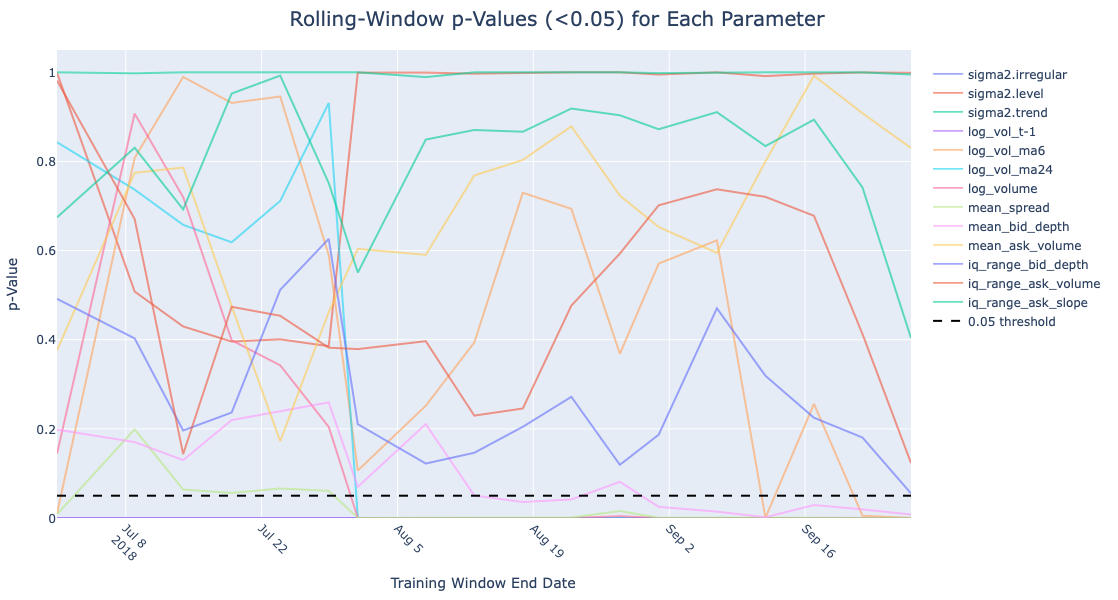

In [58]:
STRX_lltrend_expanding = back_tester(train_test_pairs=expanding_train_test_pairs,
                                   model_output_temp=model_output,
                                   order_book_feats=True,
                                   trend=True,
                                   naive=False,
                                   plot=True)

STRX_lltrend_expanding.to_csv("BSTS Results/STRX_lltrend_expanding.csv")

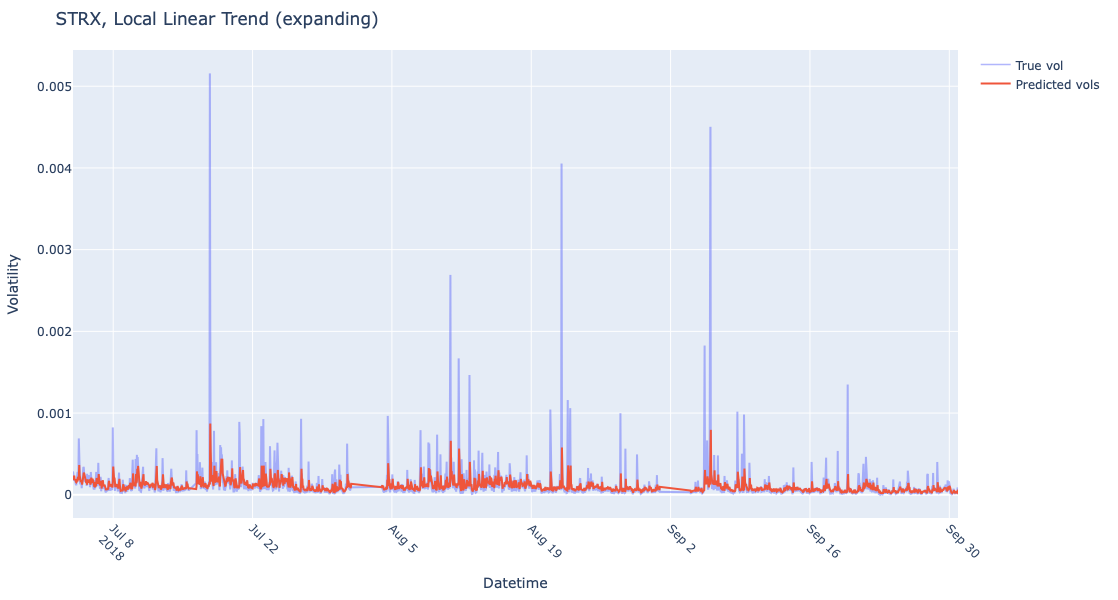

In [59]:
plot_preds(preds_dataframe=STRX_lltrend_expanding,
           model_name="Local Linear Trend",
           test_vols=test_vols,
           naive=False,
           orderbook_feats=True,
           pred_type="expanding")

In [60]:
print(f'STRX Local Linear Trend expanding RMSE = {root_mean_squared_error(STRX_lltrend_expanding["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')
print(f'STRX Local Linear Trend expanding MAE = {mean_absolute_error(STRX_lltrend_expanding["STRX"].values, np.exp(test_vols["log_vol"].values))*1e3}')

STRX Local Linear Trend expanding RMSE = 0.2293667612305932
STRX Local Linear Trend expanding MAE = 0.07402308729405402


## Observations

#### Rolling Predictions

<font size="3">When it comes to the simple STR models, it does not appear that adding a trend component to the structural time-series model significantly changes the model’s performance. Furthermore, in the p-value plots, we observe that neither the estimated level noise parameter nor the estimated trend noise parameter achieves a p-value that would make it statistically significant. While the p-value of the estimated trend noise parameter is often close to 1, the p-value of the estimated level noise parameter consistently attains lower values.<font>

<font size="3">For both STRX models we observe similar behaviour with the addition of a trend component to the model—that is, no significant change. Additionally, the p-value of the estimated trend noise parameter remains essentially equal to 1. While the p-value of the estimated level noise parameter attains lower values, they still remain relatively high.<font>

<font size="3">We also observe that the local-level STR model outperforms the local-level STRX model in both the RMSE and the MAE. We observe the same occurrence for the two local linear-trend models. These results suggest that neither adding our chosen order-book features nor adding a trend component to the structural time-series model leads to significantly different performance.
<font>

#### Expanding Predictions

<font size="3">When we use expanding training sets, we observe an overall increase in all the models' performances. Just as with the rolling predictions, adding a trend component to the STR model or the STRX model does not markedly change the models' performance. Furthermore, the p-value of the estimated trend noise parameter in both cases remains more or less constant near 1. While the p-values of the level noise parameter are generally lower, they still do not indicate statistical significance.<font>

<font size="3">The phenomenon of the simple STR models outperforming their STRX counterparts, observed for the rolling training sets, also carries over when using expanding training sets, again implying that our order-book features do not help the structural time-series models' performance.<font>